## Illustration of infered states for Soft Sticky NASCAR data

In [1]:
from bbvi_infer_2l import * 
from nascarsoft import *
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate soft sticky observations

In [2]:
K=4 ## state
D=2 ## latent dimension
T=1000 ## timesteps

In [3]:
zs_train, xs_train, ys_train, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.99, scale=0.02, speed=1, 
                                     fancy=False, gamma=0.25)
zs_test, xs_test, ys_test, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.99, scale=0.02, 
                            seed=1, speed=1, fancy=False, gamma=0.25, emission=C)

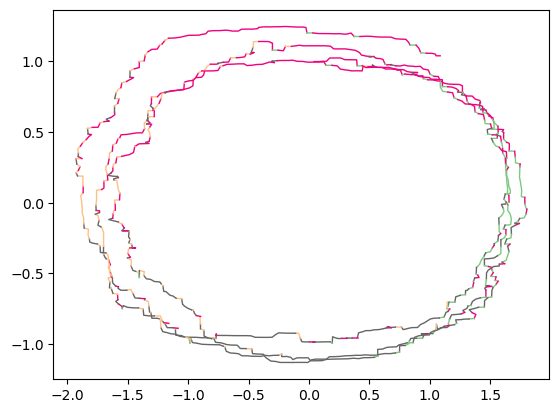

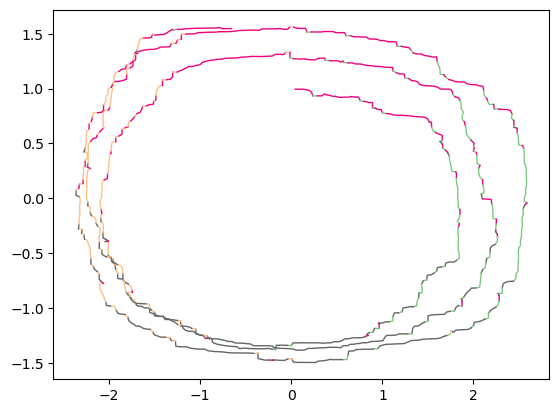

In [4]:
plot_trajectory(np.argmax(zs_train, axis=1), xs_train, ls="-")
plot_trajectory(np.argmax(zs_test, axis=1), xs_test, ls="-")

## GSD  
### GDS Train

  0%|          | 0/4000 [00:00<?, ?it/s]

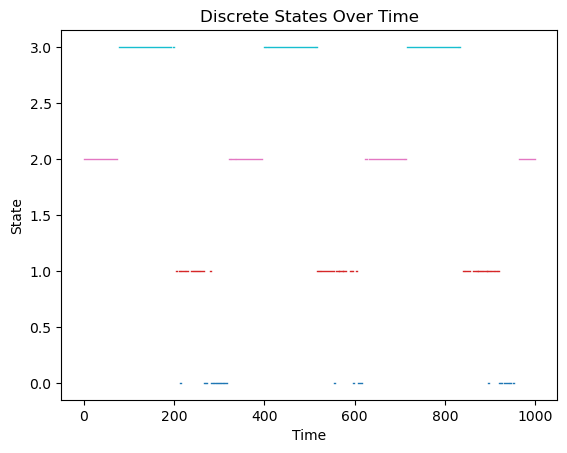

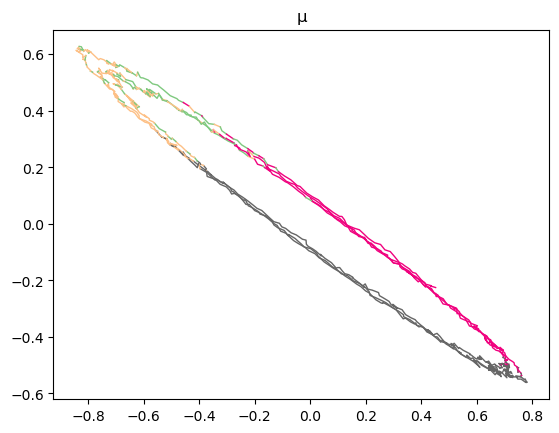

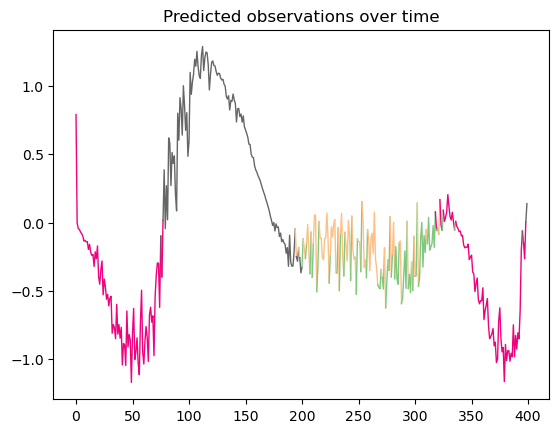

ELBO: -20838.0, LR: 0.01000, Tau: 0.990:   0%|          | 11/4000 [00:00<04:12, 15.81it/s]

R2: [-1.9726527]


ELBO: -4771.5, LR: 0.01000, Tau: 0.990:   5%|▍         | 191/4000 [00:02<00:40, 94.91it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: -4660.0, LR: 0.01000, Tau: 0.990:   5%|▍         | 191/4000 [00:02<00:40, 94.91it/s]

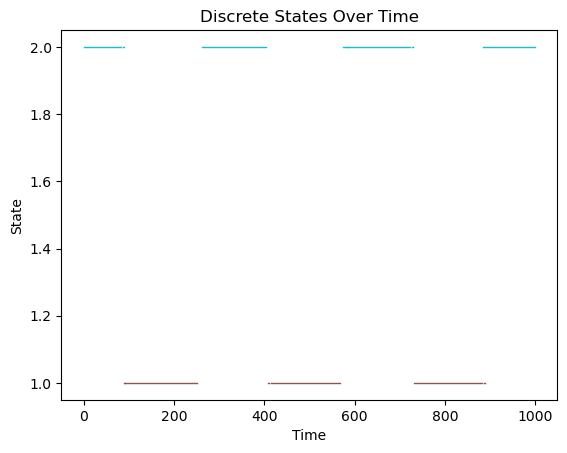

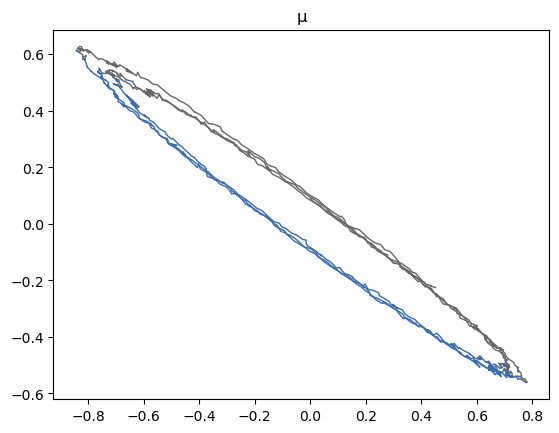

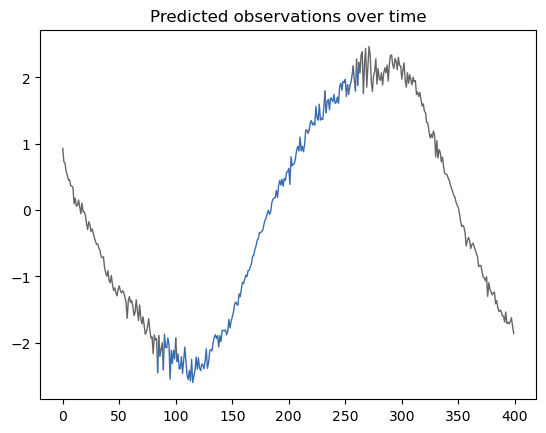

ELBO: -3912.0, LR: 0.00957, Tau: 0.990:   5%|▌         | 211/4000 [00:03<01:13, 51.74it/s]

R2: [0.97428864]


ELBO: 370.1, LR: 0.00550, Tau: 0.990:  10%|▉         | 391/4000 [00:05<00:37, 95.50it/s]  

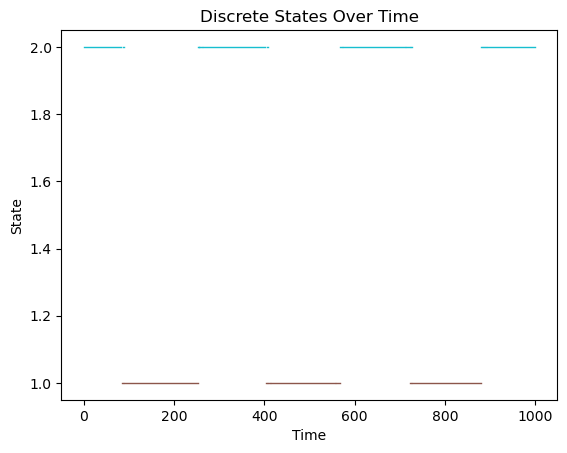

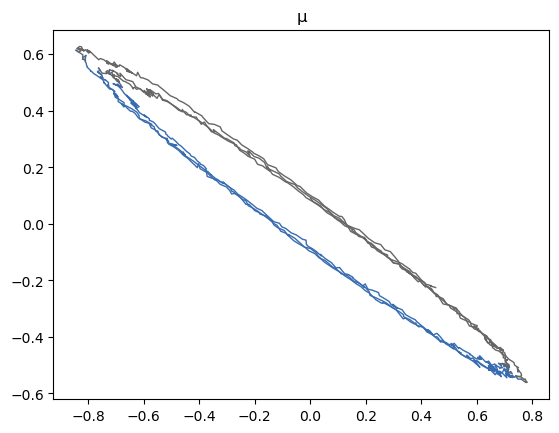

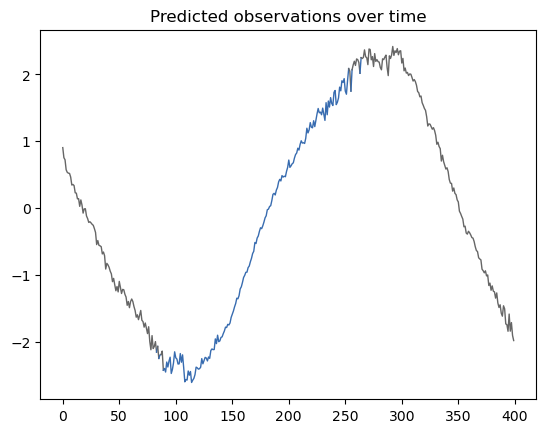

ELBO: 728.6, LR: 0.00507, Tau: 0.990:  10%|█         | 411/4000 [00:06<01:08, 52.29it/s]

R2: [0.9840177]


ELBO: 2251.3, LR: 0.00100, Tau: 0.990:  15%|█▍        | 591/4000 [00:07<00:35, 94.99it/s]

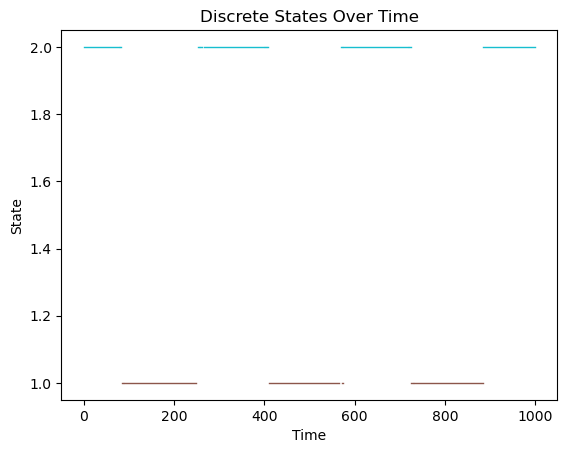

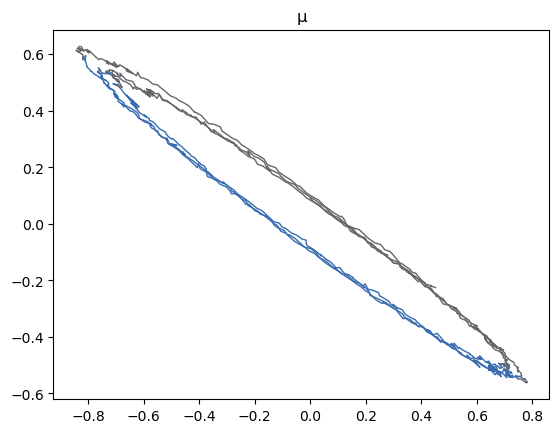

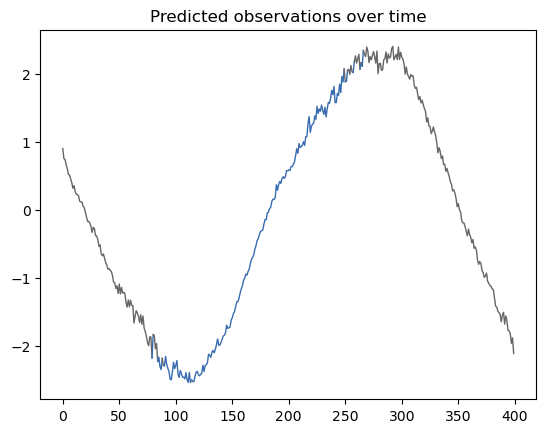

ELBO: 2221.6, LR: 0.00100, Tau: 0.990:  15%|█▌        | 611/4000 [00:08<01:04, 52.52it/s]

R2: [0.98632014]


ELBO: 2798.1, LR: 0.00100, Tau: 0.990:  20%|█▉        | 791/4000 [00:10<00:33, 94.90it/s]

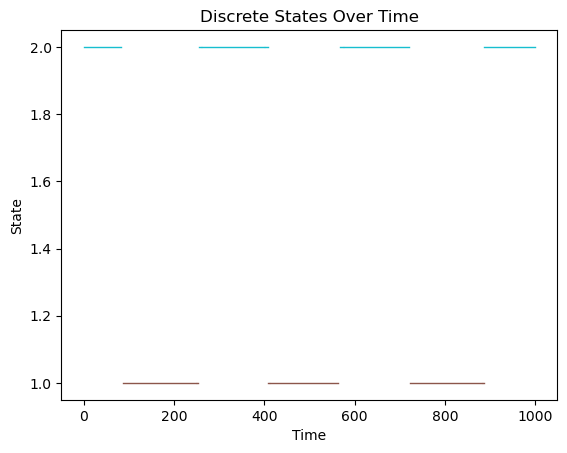

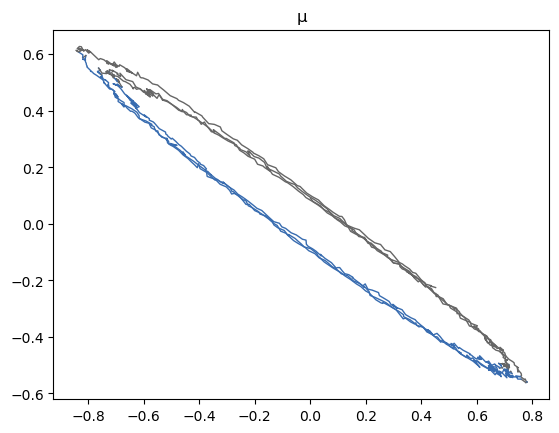

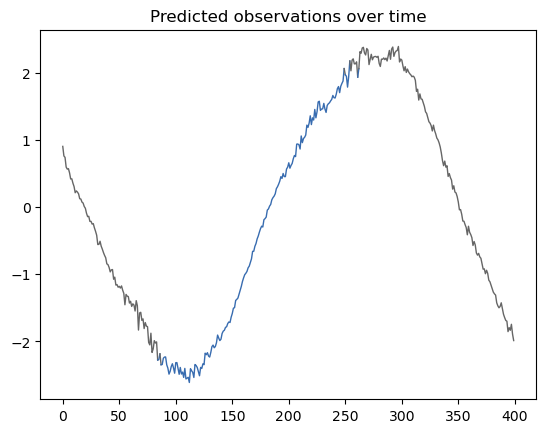

ELBO: 2798.1, LR: 0.00100, Tau: 0.990:  20%|██        | 811/4000 [00:11<00:59, 53.36it/s]

R2: [0.98724]


ELBO: 2746.6, LR: 0.00100, Tau: 0.990:  21%|██▏       | 857/4000 [00:11<00:41, 74.87it/s]

Early stopping at iteration 857.


In [5]:
torch.manual_seed(3)  # Set PyTorch seed
torch.cuda.manual_seed_all(3)  # Set CUDA seed 
model = GenerativeSLDS(N=10, K=4, D=2, emission_model="gaussian")
elbos, variational_z = fit_bbvi_schedule(model.to('cuda'), ys = torch.tensor(ys_train).to('cuda').float(), 
                                         num_iters=4000, learning=True, n_samples=10, base_lr=1e-2, 
                                         warmup_iters=200, verbose=True)

Text(0, 0.5, 'ELBO')

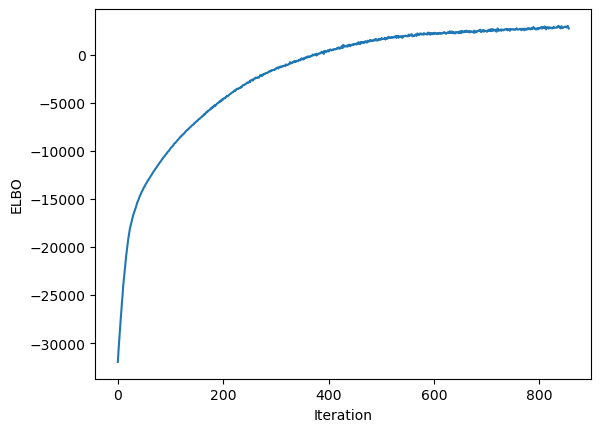

In [6]:
plt.figure()
plt.plot(elbos[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [8]:
import pickle
with open('./saved_models/nasGDM.pkl', 'wb') as file:      
    pickle.dump([model, elbos, variational_z], file) 

In [5]:
import pickle
with open('./saved_models/nasGDM.pkl', 'rb') as file:      
    model, elbos, variational_z = pickle.load(file) 

In [6]:
zs = variational_z.sample_q_z(torch.tensor(ys_train).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)
pred_ys0=model.smooth(torch.tensor(ys_train).to('cuda').float(), zs).mean(dim=0).detach().cpu().numpy() # [T, N]
y_preds, z_preds = predict_k_step_more(k_max=10, model=model, variational_z=variational_z, ys=ys_train)
print("Train accuracy:", train_metrics(ys_train, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.9882753328515804, 0.8268243942518525, 0.638016440749255, 0.5656402201226637, 0.545741596174645, 0.5409606508868625, 0.5399840534591438, 0.5395540314477548, 0.5387845638961346, 0.5377842645414195, 0.5363146713828104]


### Visualization of states

In [8]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
def plot_soft_states(zs, title="", separate_cbar=False):
    T, K = zs.shape    
    cmap_obj = plt.get_cmap("Accent", K)
    base_colors = np.array([cmap_obj(i)[:3] for i in range(K)])  # RGB only
    # Blended colors per timepoint
    blended_colors = zs @ base_colors  # (T, 3)
    alphas = zs.max(axis=1)            # confidence max prop
    # Build RGBA matrix 
    rgba = np.zeros((1, T, 4))
    rgba[0, :, :3] = blended_colors
    rgba[0, :, 3] = alphas
    
    if separate_cbar:
        fig, (ax, cax) = plt.subplots(
            1, 2, figsize=(14, 1.5),
            gridspec_kw={"width_ratios": [12, 0.1]}
        )
    else:
        # Single plot without colorbar
        fig, ax = plt.subplots(figsize=(14, 1.5))
        cax = None
    
    # Plot timeline
    ax.imshow(rgba, aspect="auto")
    ax.set_yticks([])
    ax.set_xlabel("Time point")
    ax.set_title(title)
    
    if separate_cbar:
        # Build vertical colorbar
        cmap = ListedColormap(base_colors)
        bounds = np.arange(-0.5, K, 1)
        norm = BoundaryNorm(bounds, cmap.N)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        cbar = fig.colorbar(sm, cax=cax, ticks=np.arange(K), orientation="vertical")
        cbar.set_label("Base States")
        cbar.set_ticklabels([f"State {i}" for i in range(K)])
    
    plt.tight_layout()
    plt.show()

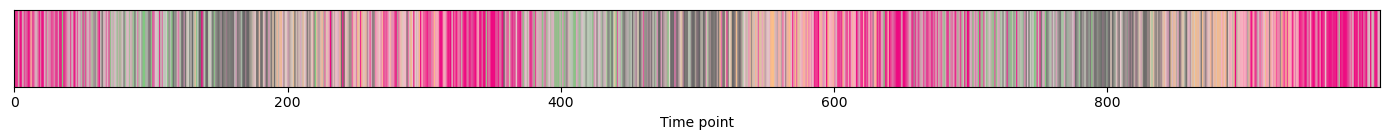

In [9]:
plot_soft_states(zs_train)

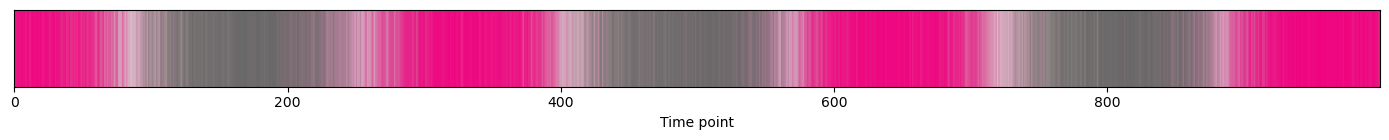

In [10]:
zs_inferred = zs.mean(dim=0).detach().cpu().numpy()
zs_inferred[:, [1, 3]] = zs_inferred[:, [3, 1]]
zs_inferred[:, [0, 1]] = zs_inferred[:, [1, 0]]
plot_soft_states(zs_inferred)

In [13]:
zs_inferred.shape

(1000, 4)

In [11]:
def plot_gs_states(zs):
    T, K = zs.shape
    cmap_obj = plt.get_cmap("Accent", K)
    fig, axes = plt.subplots(K, 1, figsize=(14, 2 * K), sharex=True)
    for k in range(K):
        axes[k].plot(zs[:, k], label=f"State {k+1}", color=cmap_obj.colors[k])
        axes[k].set_ylabel(f"$z_t^{k+1}$")
        axes[k].legend(loc="upper right")
        axes[k].grid(True)

    axes[-1].set_xlabel("Time step")
    fig.suptitle("Gumbel-Softmax State Proportions Over Time", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [15]:
from matplotlib.colors import ListedColormap, BoundaryNorm
def plot_gs_states_stacked(zs, with_colorbar=False):
    T, K = zs.shape
    cmap_obj = plt.get_cmap("Accent", K)
    base_colors = np.array([cmap_obj(i)[:3] for i in range(K)])

    fig, ax = plt.subplots(figsize=(14, 4))

    for k in range(K):
        ax.plot(
            zs[:, k],
            color=base_colors[k],
            lw=1.5
        )
    ax.set_xlabel("Time step", fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
    ax.set_title("", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True, alpha=0.3)

    if with_colorbar:
        cmap = ListedColormap(base_colors)
        bounds = np.arange(-0.5, K, 1)
        norm = BoundaryNorm(bounds, cmap.N)

        cbar = fig.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=norm),
            ax=ax,
            ticks=np.arange(K),
            orientation="vertical",
            pad=0.02
        )
        cbar.set_label("States", fontsize=14)
        cbar.set_ticklabels([f"State {i+1}" for i in range(K)])
        cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

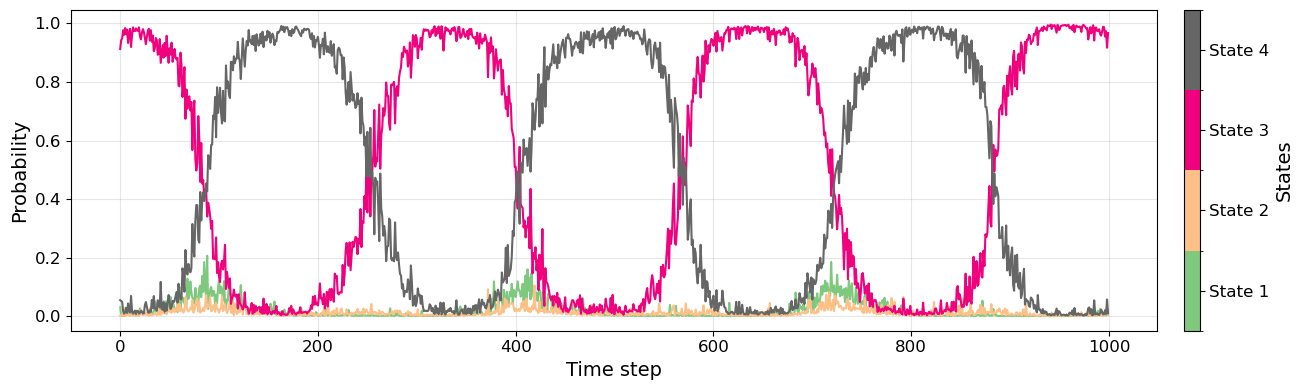

In [25]:
plot_gs_states_stacked(zs_inferred, True)

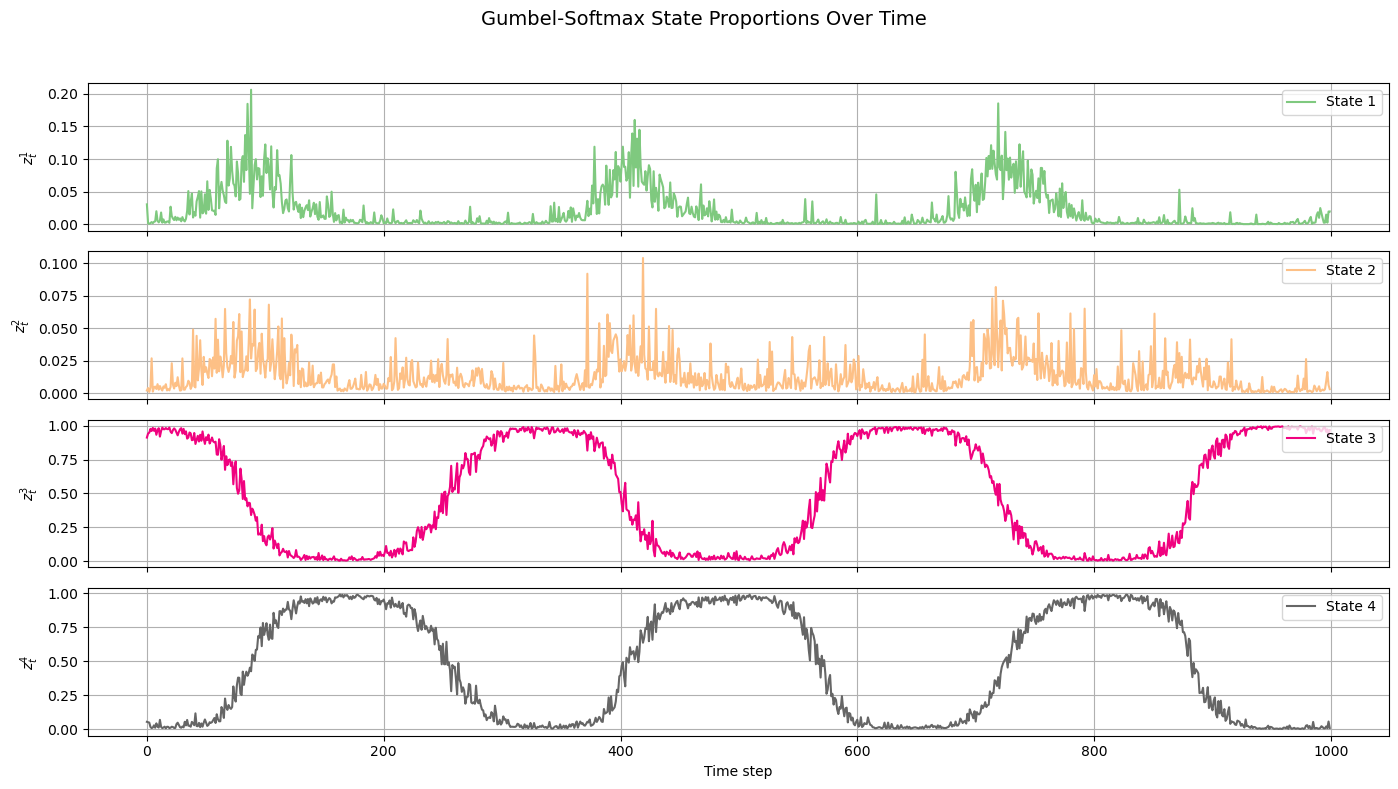

In [12]:
plot_gs_states(zs_inferred)

### GSD Test

In [7]:
zs2 = variational_z.sample_q_z(torch.tensor(ys_test).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
pred_ys2=model.smooth(torch.tensor(ys_test).to('cuda').float(), zs2).mean(dim=0).detach().cpu().numpy() # [T, N]
print("Test accuracy:", train_metrics(ys_test, pred_ys2, None, k_max=0))

Test accuracy: [0.9716434853504943]


In [8]:
### State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
Z_train = torch.mean(zs, dim=0).detach().cpu().numpy()
Y_train = np.array(zs_train.argmax(axis=1))
Z_test = torch.mean(zs2, dim=0).detach().cpu().numpy()
Y_test = np.array(zs_test.argmax(axis=1))
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)

Test accuracy: 0.715


### Prediction envelops

In [9]:
y_preds, z_t = predict_k_steps_full(model, variational_z, ys_test, k=2, n_trajectory=10, temperature=0.99)

Text(0.5, 1.0, '1-step-ahead predictions with ±3 std envelopes')

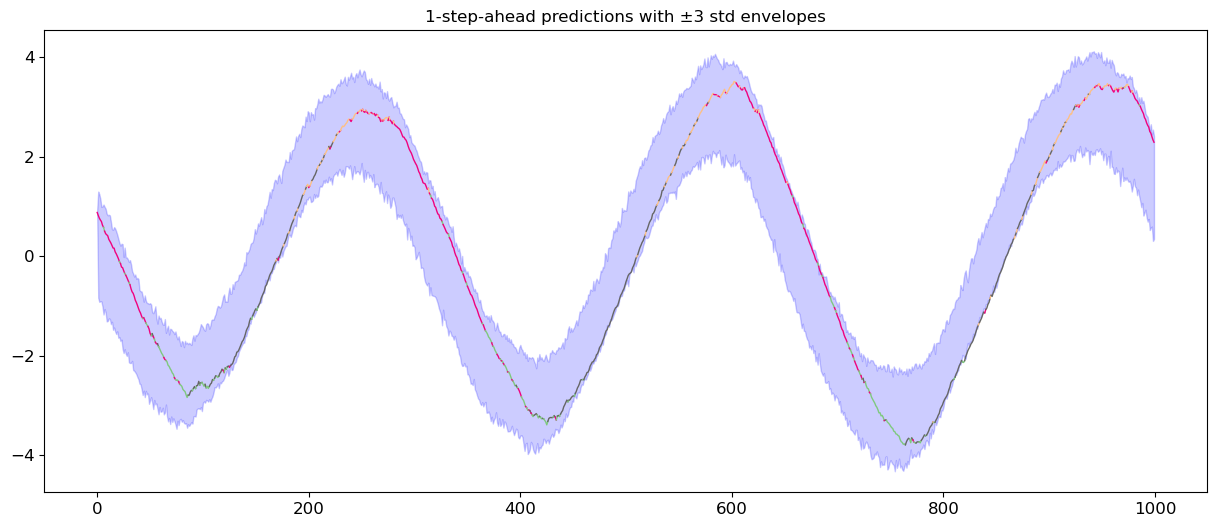

In [ ]:
fig = plt.figure(figsize=(15, 6)) 
plot_observations(np.argmax(zs_test, axis=1), ys_test[:,:1],embed=False)
## 1-step-ahead with prediction envelopes
ys_array = np.array([y_preds[1][i][:,0].cpu() for i in range(100)]) 
mean = np.mean(ys_array, axis=0)
std = np.std(ys_array, axis=0)
time = np.arange(len(ys_test))
plt.tick_params(axis="both", labelsize=12)
# plt.plot(time, mean, label='Mean', color='blue', linewidth=0.5)
plt.fill_between(time, mean - 3*std, mean + 3*std, color='blue', alpha=0.2, label='Std Dev')
plt.title("1-step-ahead predictions with ±3 std envelopes")

## Benchmarks
### Sticky rSLDS Train

In [17]:
import ssm
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions=sro_trans,
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
rslds.initialize(ys_train)
q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 22320.6: 100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


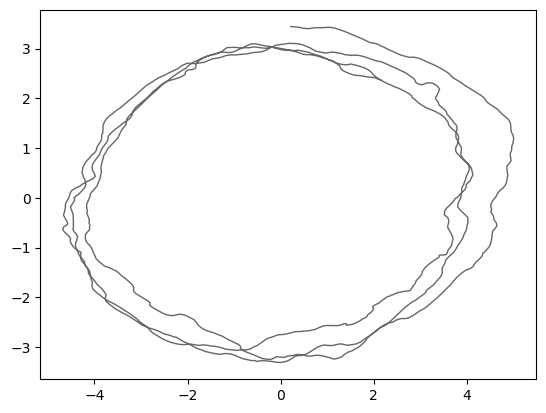

In [18]:
q_lem_x = q_lem.mean_continuous_states[0]
q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
plot_trajectory(q_lem_z, q_lem_x)

In [19]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[np.arange(T - 1), z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

In [20]:
pred_ys0 = rslds.smooth(q_lem_x, ys_train)
y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_train, k=10)
print("Train accuracy:", train_metrics(ys_train, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.9992712905621974, 0.9992718591937191, 0.9991576252837036, 0.9989576690487212, 0.9987191384239591, 0.9984589532356475, 0.9981843157808216, 0.9979062827469531, 0.997625378492214, 0.9973355201152888, 0.9970369827111508]


In [21]:
## no re-train allowed
pred_ys2=rslds.smooth(q_lem_x, ys_test)
print("Test accuracy:", train_metrics(ys_test, pred_ys2, None, k_max=0))

Test accuracy: [0.8010998688118193]


In [22]:
### State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
Z_train = np.eye(4)[q_lem_z]
Y_train = np.array(zs_train.argmax(axis=1))
Z_test = np.eye(4)[q_lem_z]
Y_test = np.array(zs_test.argmax(axis=1))
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)

Test accuracy: 0.321


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.special import rel_entr  # KL divergence
Z_train = np.eye(4)[q_lem_z]
Y_train = np.array(zs_train)
Z_test = np.eye(4)[q_lem_z]
Y_test = np.array(zs_test)
# Fit on train set 
knn = KNeighborsRegressor(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
# Predict on test set 
Y_pred = knn.predict(Z_test)
# Hard accuracy 
hard_acc = accuracy_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Test hard accuracy:", hard_acc)

#  KL divergence on test set 
eps = 1e-8
Y_true_clip = np.clip(Y_test, eps, 1)
Y_pred_clip = np.clip(Y_pred, eps, 1)
kl_divs = np.sum(rel_entr(Y_true_clip, Y_pred_clip), axis=1)
print("Mean KL divergence on test:", kl_divs.mean())

# MSE on test set (alternative) 
mse = mean_squared_error(Y_test, Y_pred)
print("Mean squared error on test:", mse)

Test hard accuracy: 0.321
Mean KL divergence on test: 1.5834363634705588
Mean squared error on test: 0.17716983278064527


### SLDS Train

In [5]:
import ssm
rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions="sticky",
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
rslds.initialize(ys_train)
q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 22343.8: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


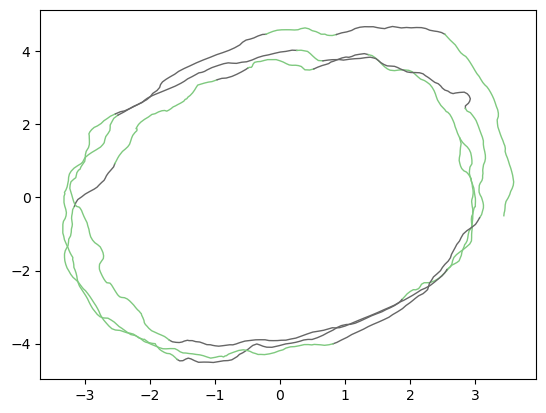

In [6]:
q_lem_x = q_lem.mean_continuous_states[0]
q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
plot_trajectory(q_lem_z, q_lem_x)

In [9]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[0,z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

In [10]:
pred_ys0 = rslds.smooth(q_lem_x, ys_train)
y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_train, k=10)
print("Train accuracy:", train_metrics(ys_train, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.9992631965196186, 0.999263732300741, 0.9991695574401327, 0.9990053018695753, 0.9988158087642531, 0.9986068373036406, 0.9983854796805444, 0.9981533313659247, 0.9978998744611222, 0.9976292526068473, 0.9973381872865268]


In [11]:
pred_ys2=rslds.smooth(q_lem_x, ys_test)
print("Test accuracy:", train_metrics(ys_test, pred_ys2, None, k_max=0))

Test accuracy: [0.8009702757058553]


In [12]:
### State quality
Z_train = np.eye(4)[q_lem_z]
Y_train = np.array(zs_train.argmax(axis=1))
Z_test = np.eye(4)[q_lem_z]
Y_test = np.array(zs_test.argmax(axis=1))
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)

Test accuracy: 0.314


### p-dLDS Train

In [10]:
from pdLDS import pdLDS
## Specify DOs
emissions_dim, latent_dim, n_dynamic_operators = 10, 2, 4
pdlds = pdLDS(emissions_dim, latent_dim, n_dynamic_operators)

In [11]:
torch.manual_seed(6)  # Set PyTorch seed
torch.cuda.manual_seed_all(6)  # Set CUDA seed 
S = 200 # offset window size
pdlds.fit(np.expand_dims(ys_train, 0), S, 
          smooth_c=True, 
          emissions_lr = 1e-3, 
          dynamics_lr = 1e-3, 
          train_iters=25, 
          weight_decay=1, 
          init_iters=5,
          init_smoothness=10, 
          xi=100)

Initializing weights with 5 iterations


log pdf: 53409.9492 c:0.0120: 100%|██████████| 5/5 [00:15<00:00,  1.73s/it]

Training with  25 iterations


log pdf: 40737.1094 c:0.0090: 100%|██████████| 25/25 [00:21<00:00,  1.14it/s]


In [12]:
import pickle
with open('./saved_models/naspdLDS.pkl', 'wb') as file:      
    pickle.dump([pdlds], file) 

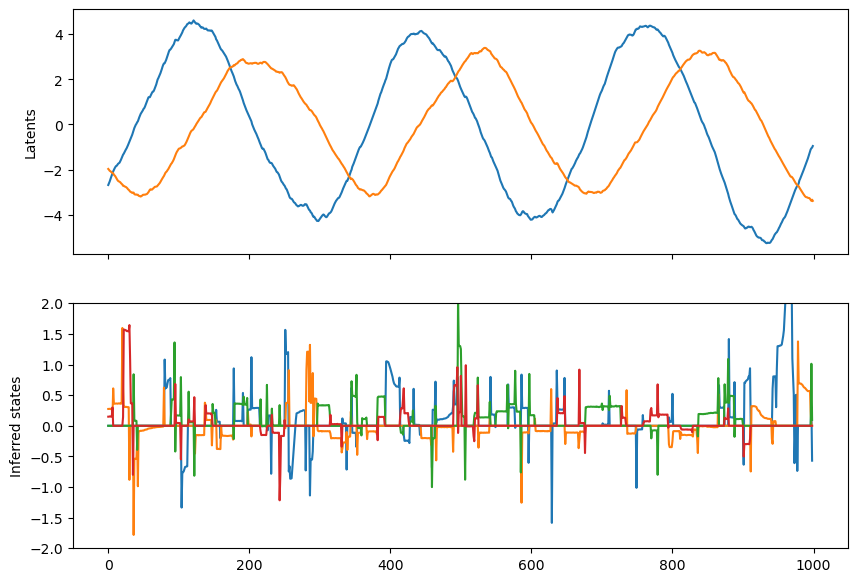

In [13]:
fig, axs = plt.subplots(2,1,figsize=(10,7), sharex=True)
## Latent dynamics
axs[0].plot(pdlds.offsets[0] + pdlds.latent[0])
axs[0].set_ylabel("Latents")
## States
axs[1].plot(pdlds.coefs[0])
axs[1].set_ylim(-2,2)
axs[1].set_ylabel("Inferred states")
plt.show()

In [14]:
## State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
offsets, latent, coefs, coefs_filt = pdlds.infer([torch.tensor(ys_test).float()])
Z_train = pdlds.coefs[0].numpy()
Y_train = np.array(zs_train.argmax(axis=1))[1:]
Z_test = coefs[0].numpy()
Y_test = np.array(zs_test.argmax(axis=1))[1:]
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc1 = knn.score(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Train accuracy:", acc1)
print("Test accuracy:", acc)

ELBO: --: 100%|██████████| 1/1 [00:12<00:00, 12.60s/it]

Train accuracy: 0.6326326326326326
Test accuracy: 0.38738738738738737


In [18]:
from matplotlib.colors import ListedColormap, BoundaryNorm
def plot_gs_states_stacked(zs, with_colorbar=False):
    T, K = zs.shape
    cmap_obj = plt.get_cmap("Accent", K)
    base_colors = np.array([cmap_obj(i)[:3] for i in range(K)])

    fig, ax = plt.subplots(figsize=(14, 4))

    for k in range(K):
        ax.plot(
            zs[:, k],
            color=base_colors[k],
            lw=1.5
        )
    ax.set_xlabel("Time step", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.set_title("", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True, alpha=0.3)

    if with_colorbar:
        cmap = ListedColormap(base_colors)
        bounds = np.arange(-0.5, K, 1)
        norm = BoundaryNorm(bounds, cmap.N)

        cbar = fig.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=norm),
            ax=ax,
            ticks=np.arange(K),
            orientation="vertical",
            pad=0.02
        )
        cbar.set_label("States", fontsize=14)
        cbar.set_ticklabels([f"State {i+1}" for i in range(K)])
        cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

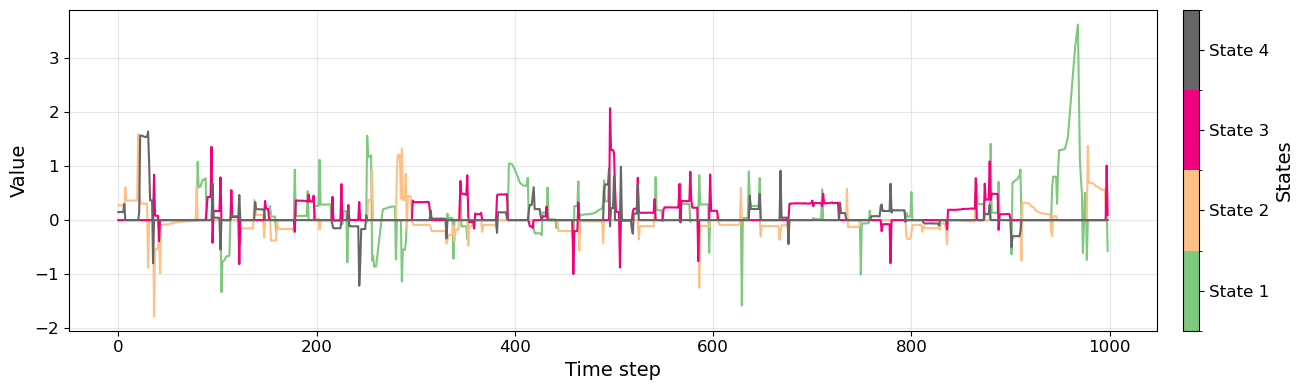

In [19]:
plot_gs_states_stacked(pdlds.coefs[0].numpy(), True)